In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
tfrecords_base_dir = '../tfrecords'
BATCH_SIZE = 1
H, W = 720, 1280

In [37]:
@tf.function
def flip_data(image, boxes, w):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        boxes = tf.stack([
            w - boxes[:, 2],
            boxes[:, 1],
            w - boxes[:, 0],
            boxes[:, 3]
        ], axis=-1)
    return image, boxes

def imshow(image):
    plt.figure(figsize=(16, 9))
    plt.axis('off')
    plt.imshow(image)
    
    
def draw_boxes_cv2(image, bbox_list, model_input_shape=[H, W]):
    img = np.uint8(image).copy()
    bbox_list = np.array(bbox_list, dtype=np.int32)
    h, w = img.shape[:2]
    h_scale, w_scale = h / H, w / W
    bbox_list = np.int32(bbox_list * np.array([w_scale, h_scale] * 2))
    for box in bbox_list:
        img = cv2.rectangle(img, (box[0], box[1]),
                            (box[2], box[3]), [30, 15, 200], 2)
    return img

def compute_area(boxes):
    h_ = boxes[:, 2] - boxes[:, 0]
    w_ = boxes[:, 3] - boxes[:, 1]
    return h_ * w_

def compute_feature_sizes(H, W):
    fm_sizes = []
    for i in range(3, 8):
        stride = 2.**i
        fm_sizes.append([tf.math.ceil(H / stride), tf.math.ceil(W / stride), stride])
    return fm_sizes
        
def get_centers(fm_h, fm_w, stride=None):
    rx = (tf.range(fm_w) + 0.5) * (stride)
    ry = (tf.range(fm_h) + 0.5) * (stride)
    sx, sy = tf.meshgrid(rx, ry)
    cyx = tf.stack([sy, sx], axis=-1)
    return cyx

def get_all_centers(H, W):
    centers_list = []
    feature_sizes = compute_feature_sizes(H, W)
    for fm_h, fm_w, stride in feature_sizes:
        cyx = get_centers(fm_h, fm_w, stride)
        cyx = tf.reshape(cyx, shape=[-1, 2])
        centers_list.append(cyx)
    return centers_list

@tf.function(input_signature=[
    tf.TensorSpec(shape=[None, 2], dtype=tf.float32),
    tf.TensorSpec(shape=[None, 5], dtype=tf.float32)
])
def compute_targets(centers, labels):
    '''
        From the FCOS paper, "Specifically, location (x, y) is
        considered as a positive sample if it falls into any 
        ground-truth box and the class label c∗ of the location is
        the class label of the ground-truth box. Otherwise it is a
        negative sample and c ∗ = 0 (background class)
        Besides the label for classification, we also have a 4D
        real vector t∗ = (l∗, t∗, r∗, b∗) being the regression
        targets for the location. Here l∗, t∗, r∗ and b∗ are the
        distances from the location to the four sides of the bounding
        box ...If a location falls into multiple bounding boxes, it is
        considered as an ambiguous sample. We simply choose the
        bounding box with minimal area as its regression target"
        Args:
            centers: (M, 2)
            labels:  (N, 5)
    '''
    boxes_ = labels[:, :4]
    class_ids_ = labels[:, 4]
    
    areas = compute_area(boxes_)
    sorted_indices = tf.argsort(areas)
    boxes = tf.gather(boxes_, indices=sorted_indices)
    class_ids = tf.gather(class_ids_, indices=sorted_indices)
    
    xy_min = boxes[:, :2]
    xy_max = boxes[:, 2:]
    lt = centers[:, None] - xy_min
    rb = xy_max - centers[:, None]
    ltrb = tf.concat([lt, rb], axis=2) # (M, N, 4)
    mask_lt = tf.logical_and(ltrb[:, :, 0] > 0, ltrb[:, :, 1] > 0)
    mask_rb = tf.logical_and(ltrb[:, :, 2] > 0, ltrb[:, :, 3] > 0)
    mask = tf.logical_and(mask_lt, mask_rb) # (M, N)
#     mask = tf.tile(mask[:, :, None], multiples=[1, 1, 4])
#     mask = tf.cast(mask, dtype=tf.float32)
#     ltrb = ltrb * mask
    return ltrb, mask

In [38]:
p3, p4, p5, p6, p7 = get_all_centers(H, W)

In [40]:
ltrb, mask = compute_targets(p6, label)

In [42]:
valid_boxes = tf.argmax(tf.cast(mask, tf.float32), axis=-1)

In [59]:
valid_boxes

<tf.Tensor: id=2043, shape=(240,), dtype=int64, numpy=
array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 14,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
       13,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  8,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0, 19, 19,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0, 19, 19,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 17,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 17,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0

In [64]:
tf.gather(ltrb, valid_boxes, axis=1)[:, 0, :]

<tf.Tensor: id=2074, shape=(240, 4), dtype=float32, numpy=
array([[-325.75296 , -296.68985 ,  335.44064 ,  312.83603 ],
       [-325.75296 , -232.68985 ,  335.44064 ,  248.83603 ],
       [-325.75296 , -168.68985 ,  335.44064 ,  184.83603 ],
       [-325.75296 , -104.68985 ,  335.44064 ,  120.83603 ],
       [-325.75296 ,  -40.68985 ,  335.44064 ,   56.83603 ],
       [-325.75296 ,   23.31015 ,  335.44064 ,   -7.163971],
       [-325.75296 ,   87.31015 ,  335.44064 ,  -71.16397 ],
       [-325.75296 ,  151.31015 ,  335.44064 , -135.16397 ],
       [-325.75296 ,  215.31015 ,  335.44064 , -199.16397 ],
       [-325.75296 ,  279.31015 ,  335.44064 , -263.16397 ],
       [-325.75296 ,  343.31015 ,  335.44064 , -327.16397 ],
       [-325.75296 ,  407.31015 ,  335.44064 , -391.16397 ],
       [-325.75296 ,  471.31015 ,  335.44064 , -455.16397 ],
       [-325.75296 ,  535.3102  ,  335.44064 , -519.16394 ],
       [-325.75296 ,  599.3102  ,  335.44064 , -583.16394 ],
       [-325.75296 ,  663.

In [4]:
feature_description = {
    'image': tf.io.FixedLenFeature([], tf.string),
    'xmins': tf.io.VarLenFeature(tf.float32),
    'ymins': tf.io.VarLenFeature(tf.float32),
    'xmaxs': tf.io.VarLenFeature(tf.float32),
    'ymaxs': tf.io.VarLenFeature(tf.float32),
    'labels': tf.io.VarLenFeature(tf.float32)
}

@tf.function
def parse_example(example_proto):
    parsed_example = tf.io.parse_single_example(
        example_proto, feature_description)
    image = tf.image.decode_jpeg(parsed_example['image'], channels=3)
    bboxes = tf.stack([
        tf.sparse.to_dense(parsed_example['xmins']),
        tf.sparse.to_dense(parsed_example['ymins']),
        tf.sparse.to_dense(parsed_example['xmaxs']),
        tf.sparse.to_dense(parsed_example['ymaxs'])
    ], axis=-1)
    class_ids = tf.reshape(tf.sparse.to_dense(
        parsed_example['labels']), [-1, 1])
    return image, bboxes, class_ids

def load_data(input_shape):
    h, w = input_shape
    @tf.function
    def load_data_(example_proto, input_shape=input_shape):
        image, boxes_, class_ids = parse_example(example_proto)
        image.set_shape([None, None, 3])
        image = tf.image.resize(image, size=[h, w])
        boxes = tf.stack([
            tf.clip_by_value(boxes_[:, 0] * w, 0, w),
            tf.clip_by_value(boxes_[:, 1] * h, 0, h),
            tf.clip_by_value(boxes_[:, 2] * w, 0, w),
            tf.clip_by_value(boxes_[:, 3] * h, 0, h)
        ], axis=-1)
        image, boxes = flip_data(image, boxes, w)
        label = tf.concat([boxes, class_ids], axis=-1)
        return image, label
    return load_data_

train_files = tf.data.Dataset.list_files('{}/train*'.format(tfrecords_base_dir))
train_dataset = train_files.interleave(tf.data.TFRecordDataset,
                                       cycle_length=16,
                                       block_length=16,
                                       num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.map(
    load_data([H, W]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(512)
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True).repeat()
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
train_dataset

<DatasetV1Adapter shapes: ((1, 720, 1280, 3), (1, None, 5)), types: (tf.float32, tf.float32)>

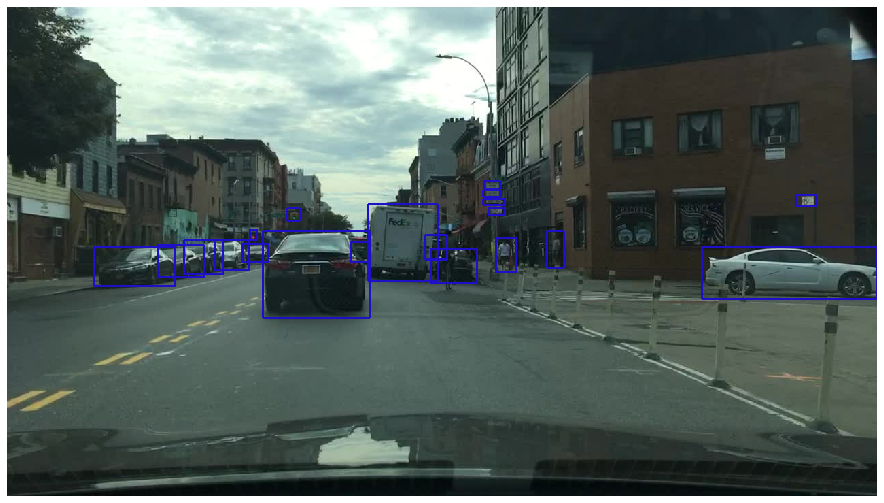

In [7]:
for x in train_dataset.take(1):
    image, label = x
image = image[0]
label = label[0]
image = image.numpy()
boxes = label[:, :4].numpy()
i = draw_boxes_cv2(image, boxes)
imshow(i)